### Compare Calibrations for WMO 5903264
*Perform oxygen calibration on float that as DOXY, but not DOXY_ADJUSTED*

Load data for float 5903264 specifying the variables (non- "\_ADJUSTED")

```bash
load_biofloat_cache.py --wmo 5903264 --bio_list DOXY --variables TEMP PSAL DOXY -v
```

Instatiate an ArgoData object specifying variables to load into the DataFrame

In [1]:
import sys
sys.path.insert(0, '../')
from biofloat import ArgoData
ad = ArgoData(cache_file='/home/mccann/biofloat_fixed_cache_wmo5903264.hdf', bio_list=('DOXY',),
              variables=('DOXY', 'PSAL', 'TEMP'))

Get the DataFrame

In [2]:
%%time
wmo_list = ['5903264']
df = ad.get_float_dataframe(wmo_list)

CPU times: user 5min 38s, sys: 11.4 s, total: 5min 49s
Wall time: 6min 24s


In [3]:
df.head()

PSAL  \
wmo     time                       lon      lat    profile pressure              
5903264 2015-11-20 21:08:40.041600 -136.062 -49.09 587     4.62      34.320000   
                                                           6.52      34.323002   
                                                           8.52      34.325001   
                                                           10.52     34.327000   
                                                           12.52     34.327999   

                                                                           DOXY  \
wmo     time                       lon      lat    profile pressure               
5903264 2015-11-20 21:08:40.041600 -136.062 -49.09 587     4.62      259.004486   
                                                           6.52      259.254456   
                                                           8.52      258.386993   
                                                           10.52     254.661835   
                                                           12.52     256.021301   

                                                                      TEMP  
wmo     time                       lon      lat    profile pressure         
5903264 2015-11-20 21:08:40.041600 -136.062 -49.09 587     4.62      9.902  
                                                           6.52      9.896  
                                                           8.52      9.895  
                                                           10.52     9.893  
                                                           12.52     9.892

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


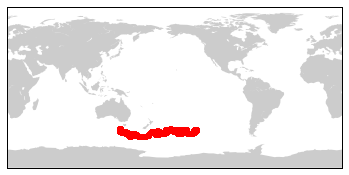

In [5]:
%pylab inline
import pylab as plt
from mpl_toolkits.basemap import Basemap

def map(lons, lats):
    m = Basemap(llcrnrlon=15, llcrnrlat=-90, urcrnrlon=390, urcrnrlat=90, projection='cyl')
    m.fillcontinents(color='0.8')
    m.scatter(lons, lats, latlon=True, color='red')

map(df.index.get_level_values('lon'), df.index.get_level_values('lat'))

In [6]:
sdf = df.query('pressure < 10').groupby(level=['wmo', 'time', 'lon', 'lat']).mean()
sdf['lon'] = sdf.index.get_level_values('lon')
sdf['lat'] = sdf.index.get_level_values('lat')
sdf['month'] = sdf.index.get_level_values('time').month
sdf['year'] = sdf.index.get_level_values('time').year
sdf['wmo'] = sdf.index.get_level_values('wmo')

In [7]:
msdf = sdf.groupby(['wmo', 'year', 'month']).mean()
from biofloat.utils import o2sat, convert_to_mll
msdf['o2sat'] = 100 * (msdf.DOXY / o2sat(msdf.PSAL, msdf.TEMP))

In [8]:
def round_to(n, increment, mark):
    correction = mark if n >= 0 else -mark
    return int( n / increment) + correction

imsdf = msdf.copy()
imsdf['ilon'] = msdf.apply(lambda x: round_to(x.lon, 1, 0.5), axis=1)
imsdf['ilat'] = msdf.apply(lambda x: round_to(x.lat, 1, 0.5), axis=1)

In [9]:
woa_tmpl = 'http://data.nodc.noaa.gov/thredds/dodsC/woa/WOA13/DATA/o2sat/netcdf/all/1.00/woa13_all_O{:02d}_01.nc'
woa = {}
for m in range(1,13):
    woa[m] = woa_tmpl.format(m)

In [10]:
import xray
def woa_o2sat(month, depth, lon, lat):
    ds = xray.open_dataset(woa[month], decode_times=False)
    return ds.loc[dict(lon=lon, lat=lat, depth=depth)]['O_an'].values[0]

In [11]:
%%time
woadf = imsdf.copy()
woadf['month'] = woadf.index.get_level_values('month')
woadf['woa_o2sat'] = woadf.apply(lambda x: woa_o2sat(x.month, 5.0, x.ilon, x.ilat), axis=1)

CPU times: user 1.53 s, sys: 151 ms, total: 1.68 s
Wall time: 1min 23s


In [12]:
gdf = woadf[['o2sat', 'woa_o2sat']].copy()
gdf['wmo'] = gdf.index.get_level_values('wmo')
years = gdf.index.get_level_values('year')
months = gdf.index.get_level_values('month')

/home/mccann/VirtualEnvs/biofloat/lib/python2.7/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


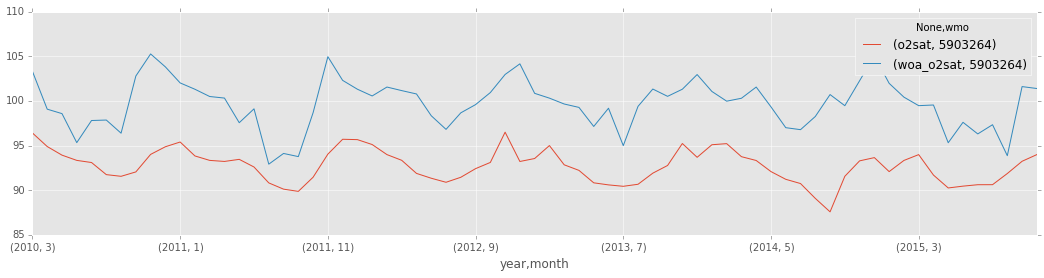

In [13]:
import matplotlib as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18.0, 4.0)
gdf[['o2sat', 'woa_o2sat']].unstack(level=0).plot()

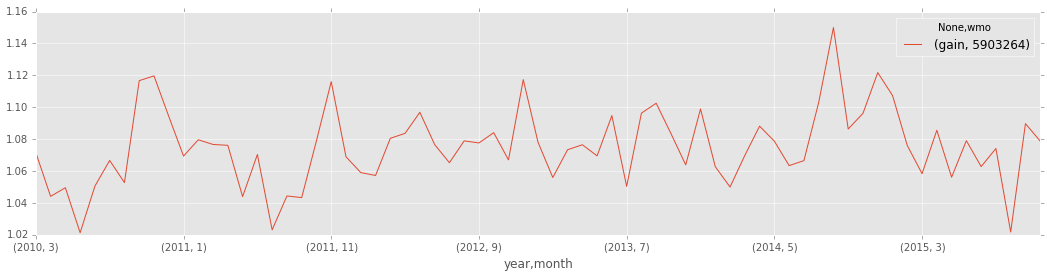

In [14]:
gdf['gain'] = gdf.woa_o2sat / gdf.o2sat
gdf[['gain']].unstack(level=0).plot()

In [15]:
gdf.groupby('wmo').gain.mean()

wmo
5903264    1.075242
Name: gain, dtype: float64